# MOVIE RECOMMENDATION SYSTEM

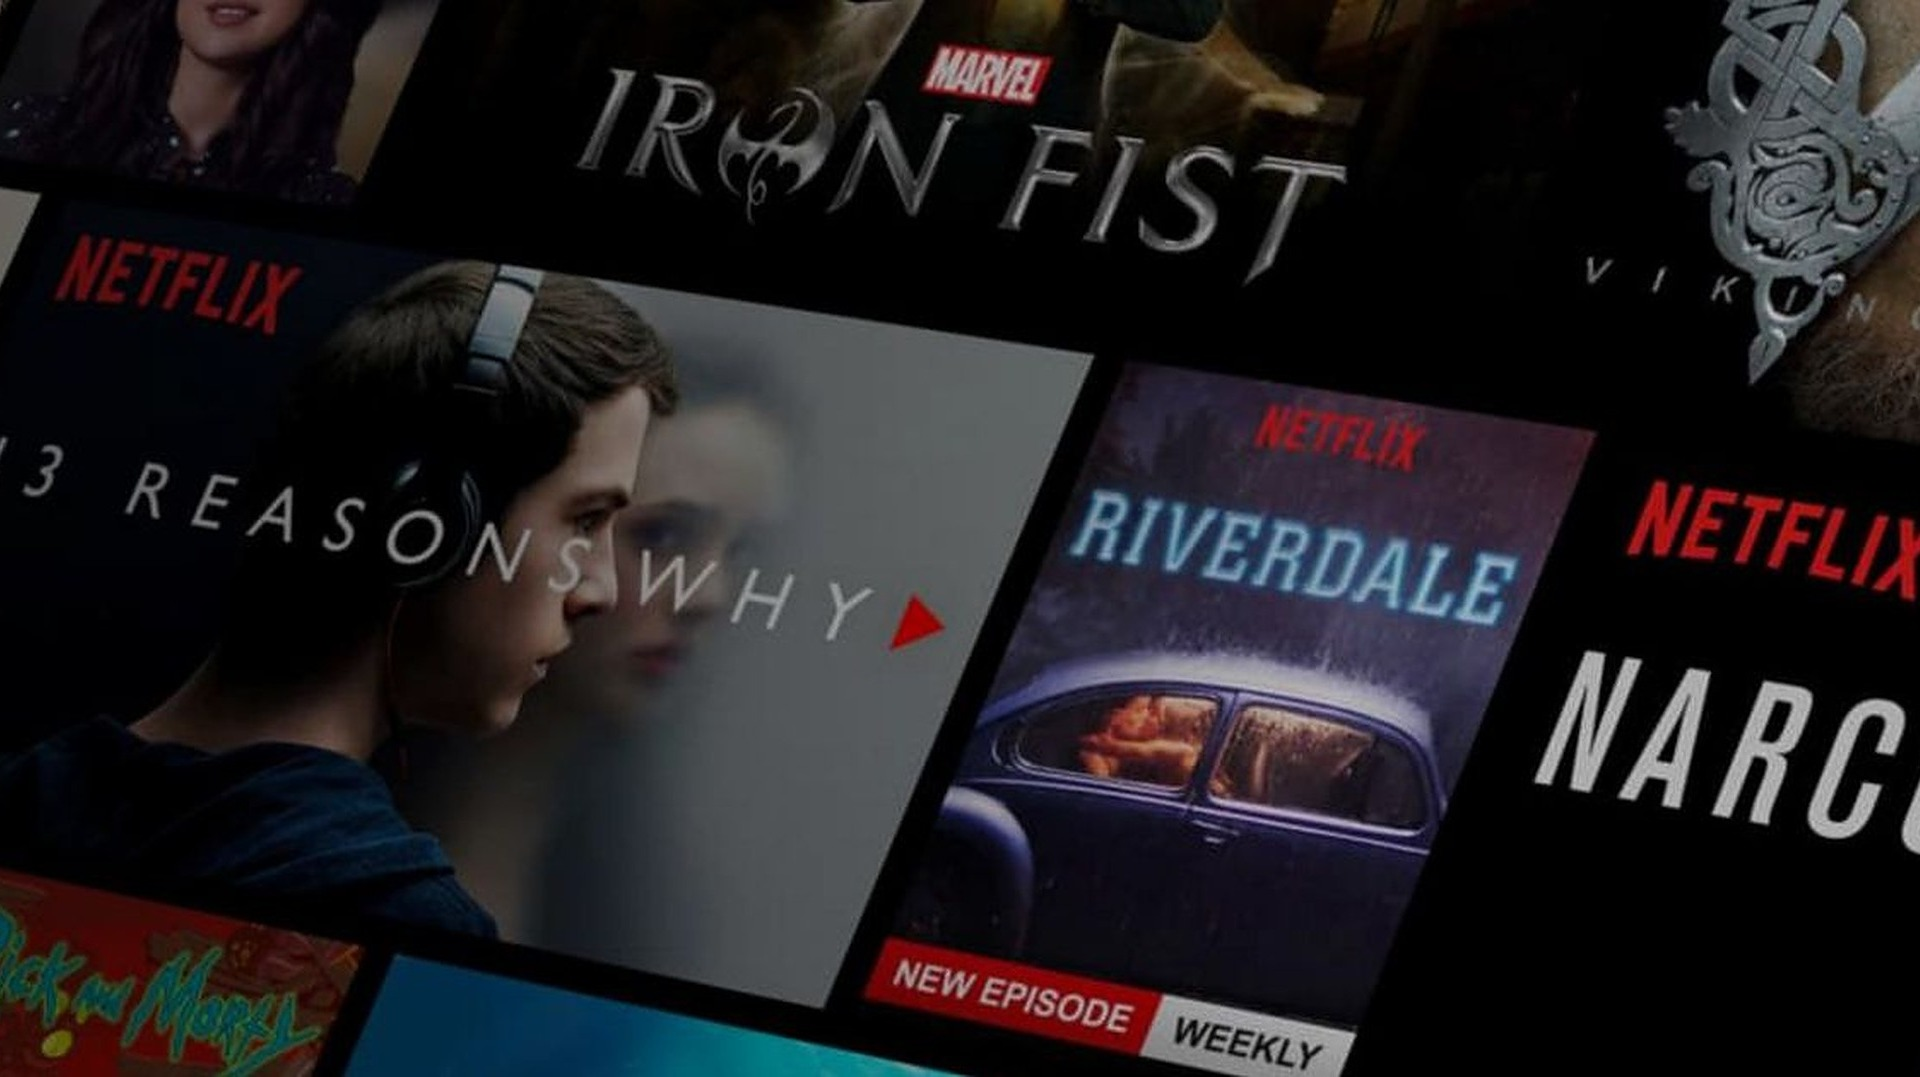

In [1]:
from PIL import Image
Image.open("./76889recommender-system-for-movie-recommendation.jpg")

## Project Overview
<p>This project aims to build an accurate movie recommendation system. It is a Content Based recommendation system. It based on Genre and Ratings. The project uses Count Vectorization and Cosine Similarity to find similarity throughout the Genre. Later the recommended list is sorted through Ratings. The cleaned Dataset and the model is saved. The web app is streamed using streamlit library of python. It takes a movie name as input and the detail of the input movie is displayed. Along with 5 most recommended movie is displayed. It redirects to the IMDb website when the title of movies are clicked.</p>

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imdb
from PIL import Image
import requests
from io import BytesIO
import warnings 
warnings.filterwarnings("ignore")

## Import dataset

In [3]:
movieSet = pd.read_csv("./imdb-movies-dataset.csv")

In [4]:
movieSet.head()

,Poster,Title,Year,Certificate,Duration (min),Genre,Rating,Metascore,Director,Cast,Votes,Description,Review Count,Review Title,Review
0,https://m.media-amazon.com/images/M/MV5BYWRkZj...,The Idea of You,2023.0,R,115.0,"Comedy, Drama, Romance",6.4,67.0,Michael Showalter,"Anne Hathaway, Nicholas Galitzine, Ella Rubin,...","28,744","Solène, a 40-year-old single mom, begins an un...",166,Hypocrisy as an idea,"This film, as well as the reaction to it, is a..."
1,https://m.media-amazon.com/images/M/MV5BZGI4NT...,Kingdom of the Planet of the Apes,2023.0,PG-13,145.0,"Action, Adventure, Sci-Fi",7.3,66.0,Wes Ball,"Owen Teague, Freya Allan, Kevin Durand, Peter ...","22,248","Many years after the reign of Caesar, a young ...",183,A phenomenal start to another trilogy!,"I'm a big fan of all the planet of the apes, a..."
2,https://m.media-amazon.com/images/M/MV5BZjIyOT...,Unfrosted,2023.0,PG-13,97.0,"Biography, Comedy, History",5.5,42.0,Jerry Seinfeld,"Isaac Bae, Jerry Seinfeld, Chris Rickett, Rach...","18,401","In 1963 Michigan, business rivals Kellogg's an...",333,not funny,Pretty much the worst criticism you can lay on...
3,https://m.media-amazon.com/images/M/MV5BMjA5Zj...,The Fall Guy,2023.0,PG-13,126.0,"Action, Comedy, Drama",7.3,73.0,David Leitch,"Ryan Gosling, Emily Blunt, Aaron Taylor-Johnso...","38,953",A down-and-out stuntman must find the missing ...,384,Everything you needed and more!,Just got out of the Austin premier at SXSW and...
4,https://m.media-amazon.com/images/M/MV5BNTk1MT...,Challengers,2023.0,R,131.0,"Drama, Romance, Sport",7.7,82.0,Luca Guadagnino,"Zendaya, Mike Faist, Josh O'Connor, Darnell Ap...","32,517","Tashi, a former tennis prodigy turned coach, t...",194,"Watch ""Match Point"" instead",This is a tough one. I liked the concept and t...


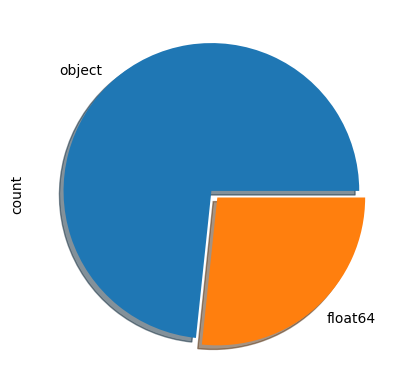

In [5]:
movieSet.dtypes.value_counts().plot.pie(shadow=True,explode=[0.03,0.03],autopct=None)
plt.show()

In [6]:
movieSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Poster          10000 non-null  object 
 1   Title           10000 non-null  object 
 2   Year            9850 non-null   float64
 3   Certificate     7370 non-null   object 
 4   Duration (min)  9664 non-null   float64
 5   Genre           9993 non-null   object 
 6   Rating          9596 non-null   float64
 7   Metascore       7555 non-null   float64
 8   Director        9995 non-null   object 
 9   Cast            9961 non-null   object 
 10  Votes           9596 non-null   object 
 11  Description     10000 non-null  object 
 12  Review Count    9999 non-null   object 
 13  Review Title    9483 non-null   object 
 14  Review          9484 non-null   object 
dtypes: float64(4), object(11)
memory usage: 1.1+ MB


In [7]:
# Searching for null values
movieSet.isna().sum()

Poster               0
Title                0
Year               150
Certificate       2630
Duration (min)     336
Genre                7
Rating             404
Metascore         2445
Director             5
Cast                39
Votes              404
Description          0
Review Count         1
Review Title       517
Review             516
dtype: int64

### As we can see Votes and review title must convert to numerical

## Data Clean

In [8]:
## Cleaning the Vote 
for i in range(movieSet.Votes.size):
    try:
        movieSet.Votes[i] = float("".join(movieSet.Votes[i].split(",")))
    except:
        movieSet.Votes[i]=float(movieSet.Votes[i])
movieSet.Votes = movieSet.Votes.fillna(movieSet.Votes.mean())

In [9]:
## Cleaning the Review Counts
for i in range(movieSet["Review Count"].size):
    try:
        movieSet["Review Count"][i] = float("".join(movieSet["Review Count"][i].split(",")))
    except:
        movieSet["Review Count"][i] = float(movieSet["Review Count"][i])
movieSet["Review Count"].fillna(movieSet["Review Count"].mean(),inplace = True)

In [10]:
## Removing null values form caste
movieSet.dropna(subset=["Cast","Genre","Director"],inplace=True,axis=0)
movieSet.reset_index(inplace=True)

In [11]:
movieSet.drop(["index","Poster"],axis=1,inplace=True)

In [12]:
# forward filling the Ratings 
movieSet.Rating.ffill(inplace=True)

In [13]:
# droping useless columns and null rows
movieSet.dropna(subset=["Year","Certificate","Duration (min)"],axis=0,inplace=True)
movieSet.drop(["Metascore","Review Title","Review","Review Count","Votes"],axis=1,inplace=True)

for i in movieSet.Year.index:
    try:
        movieSet.Year[i] = int("".join(movieSet.Year[i].split(",")))
    except:
        movieSet.Year[i] = int(movieSet.Year[i])

In [14]:
# Confirming the cleanliness of dataset
movieSet.isna().sum()

Title             0
Year              0
Certificate       0
Duration (min)    0
Genre             0
Rating            0
Director          0
Cast              0
Description       0
dtype: int64

## Analysis

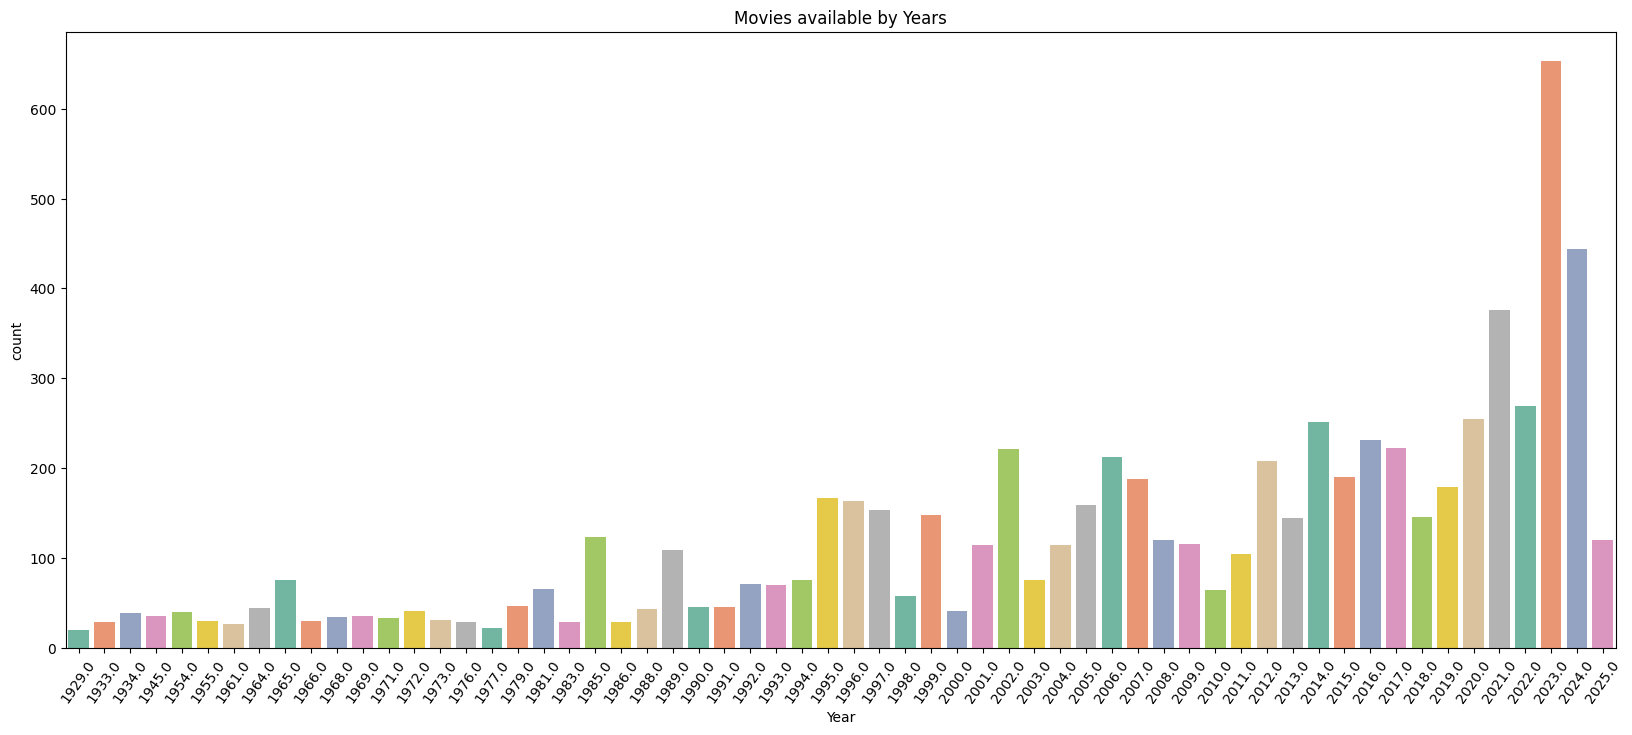

In [15]:
plt.figure(figsize=(20,8))
plt.title("Movies available by Years")
sns.countplot(data = movieSet,x="Year",palette="Set2")
plt.xticks(rotation=55)
plt.show()

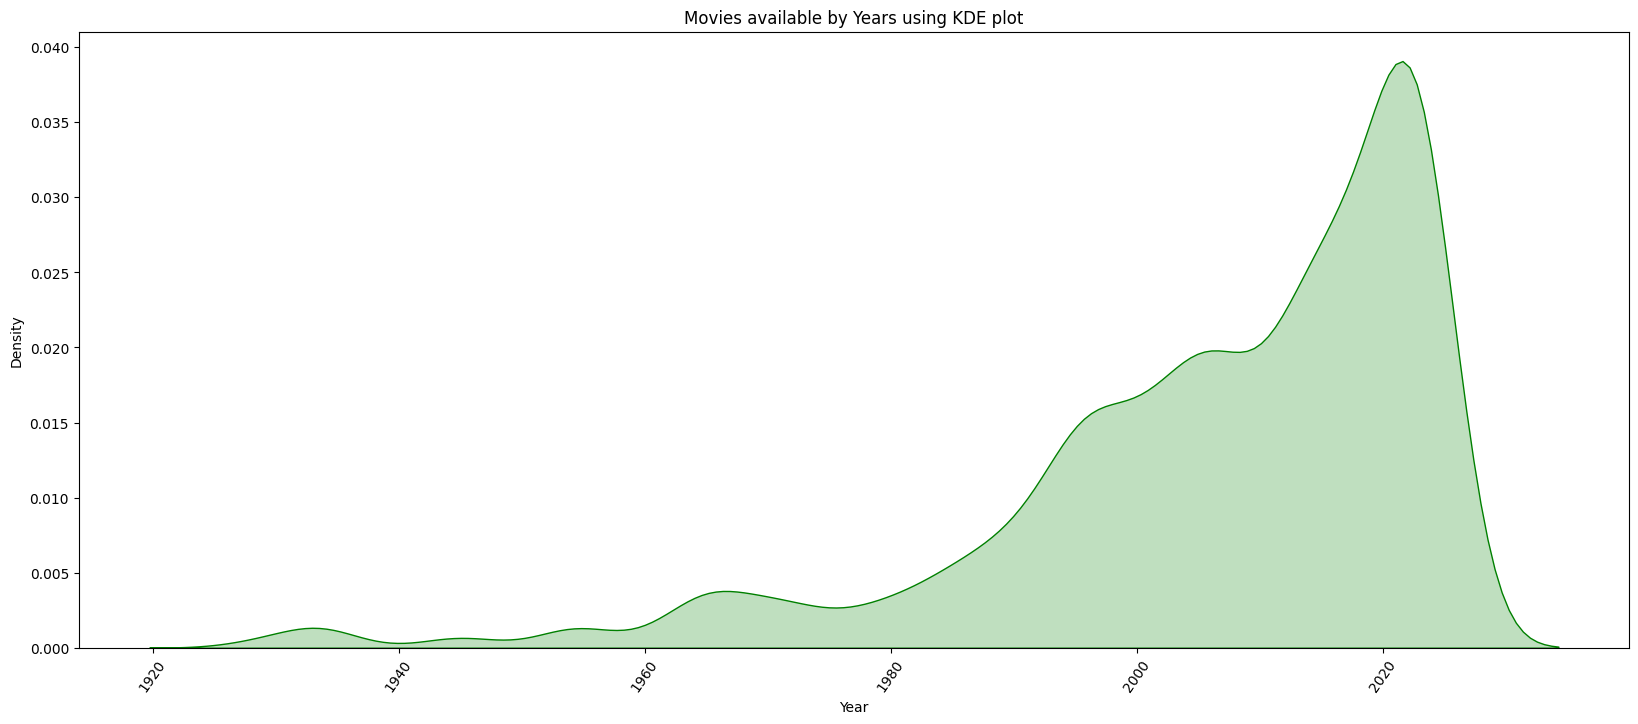

In [16]:
plt.figure(figsize=(20,8))
plt.title("Movies available by Years using KDE plot")
sns.kdeplot(data = movieSet,x="Year",palette="Set2",fill=True,color="Green")
plt.xticks(rotation=55)
plt.show()

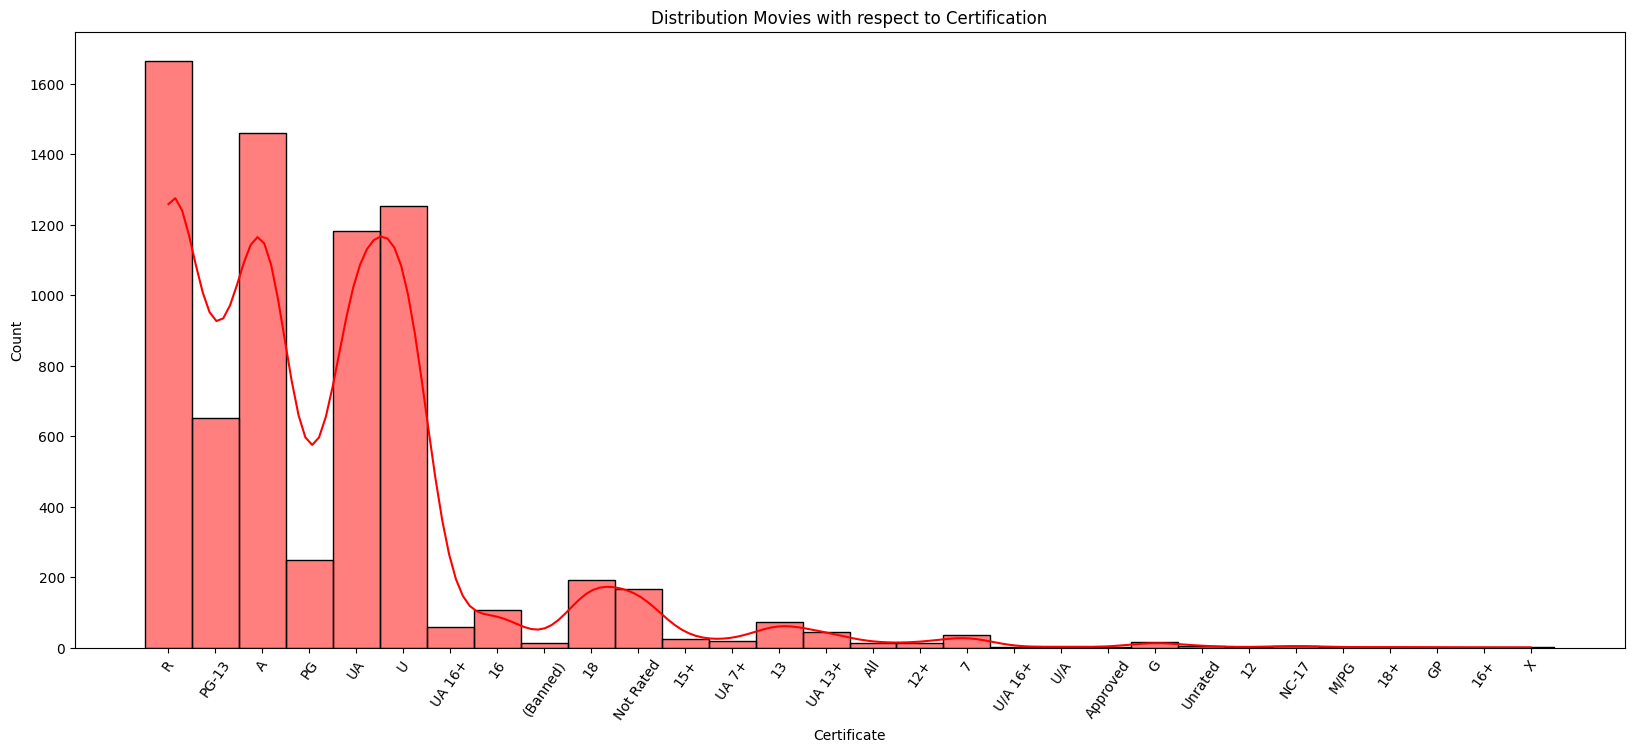

In [17]:
plt.figure(figsize=(20,8))
sns.histplot(movieSet.Certificate,kde=True,color="Red")
plt.title("Distribution Movies with respect to Certification")
plt.xticks(rotation=55)
plt.show()

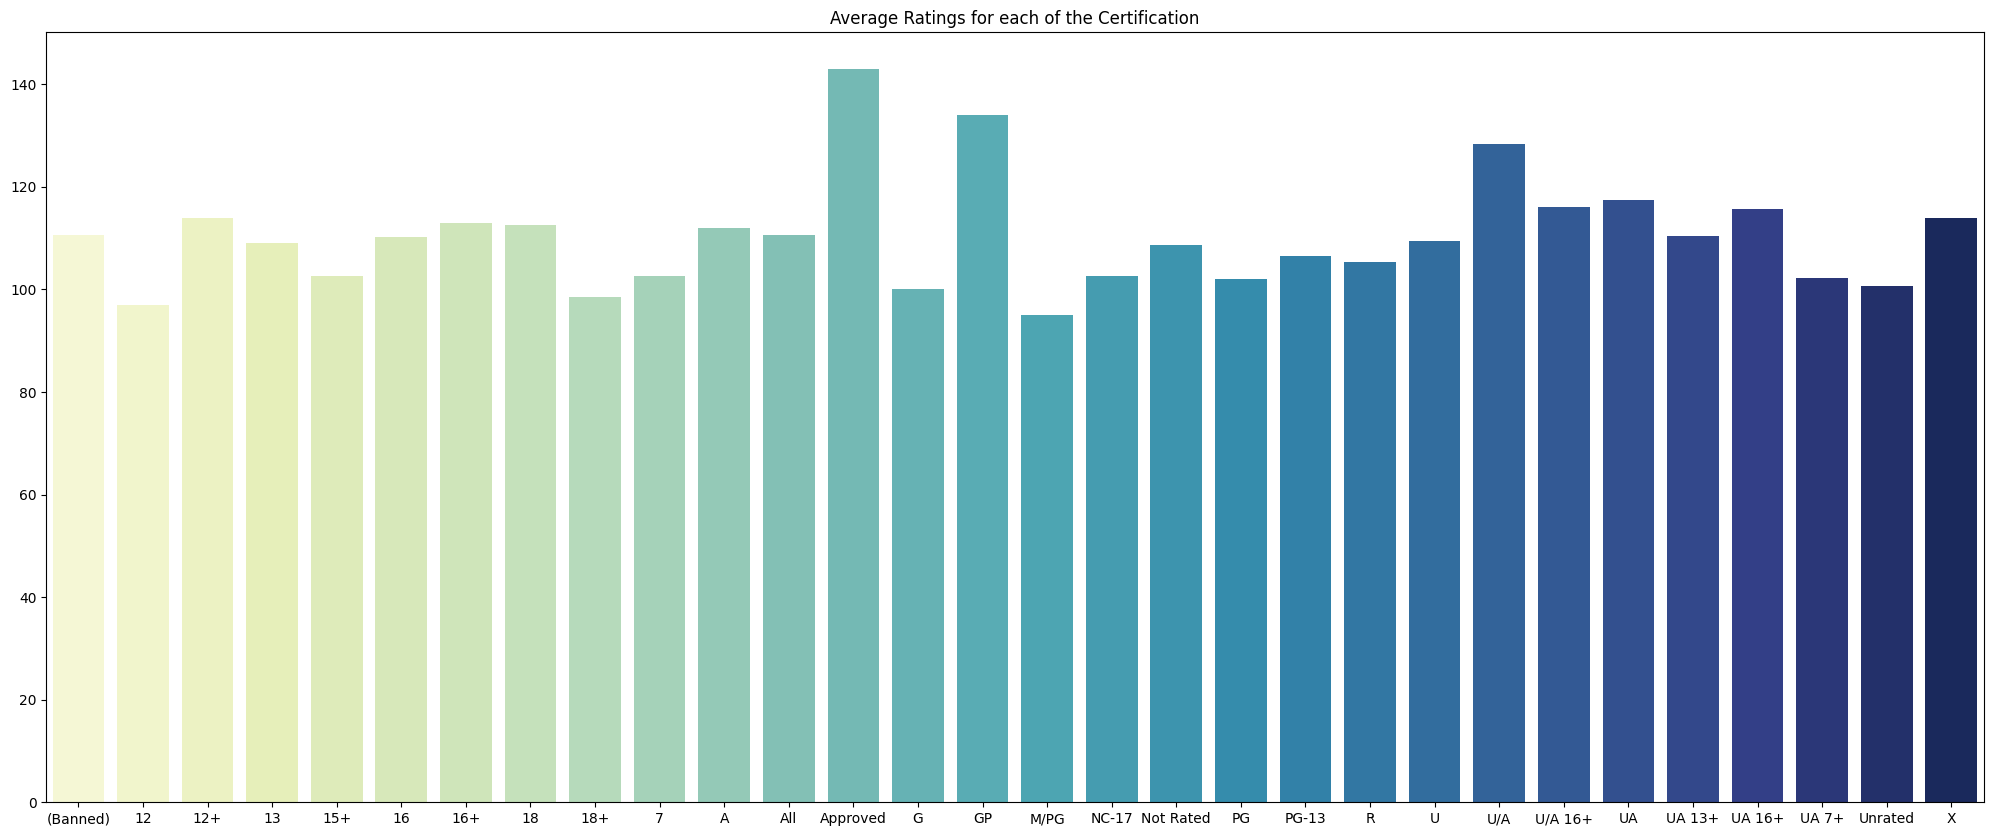

In [18]:
# average Run Time for each certificate category
Cgroup = movieSet.groupby("Certificate")["Duration (min)"]
dC_T = {}
for i in Cgroup:
    dC_T[i[0]]=i[1].mean().round(2)
# plot
plt.figure(figsize=(25,10))
sns.barplot(x = dC_T.keys(),y = dC_T.values(),palette="YlGnBu")
plt.title("Average Ratings for each of the Certification")
plt.show()

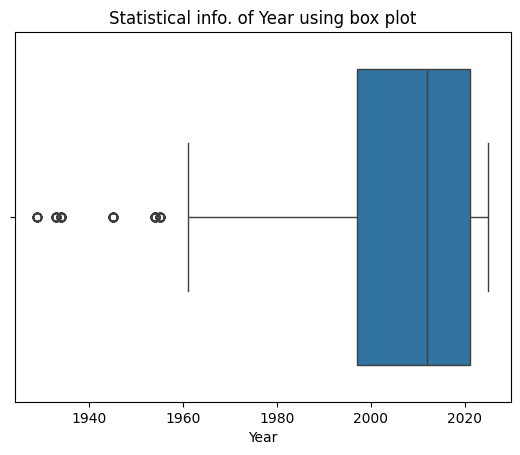

In [19]:
# Statistical info of Year using box plot
sns.boxplot(data=movieSet,x="Year")
plt.title("Statistical info. of Year using box plot")
plt.show()

## Reccomendation System

In [20]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
vecorizer = CountVectorizer(max_features=10000)
vectorized = vecorizer.fit_transform(movieSet.Genre)

In [22]:
# using cosine similarity to check on similar Genre
similarityData = cosine_similarity(vectorized)

In [23]:
movieSet.Title = movieSet.Title.str.strip()

In [24]:
# saving the model and the cleaned csv file
import joblib 
joblib.dump(similarityData,"similarity.pkl")
movieSet.to_csv("filteredSet.csv",index=False)